### Transformer

In [ ]:
#from transformers import pipeline
#import pandas as pd

#sent = pipeline("sentiment-analysis", model="oliverguhr/german-sentiment-bert")

#def clip(s, n=1000):  # lange Reden kappen für BERT
    #return s[:n] if isinstance(s, str) else s

#df = df.dropna(subset=["text"]).copy()
#df["sent_raw"]   = df["text"].apply(lambda s: sent(clip(s))[0])
#df["sent_label"] = df["sent_raw"].str["label"]      # positive/neutral/negative
#df["sent_score"] = df["sent_raw"].str["score"]      # Konfidenz
#label2num = {"negative": -1, "neutral": 0, "positive": 1}
#df["sent_num"]   = df["sent_label"].map(label2num)


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

C:\Users\noahg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\noahg\.cache\huggingface\hub\models--oliverguhr--german-sentiment-bert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/161 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


## Load

In [18]:
pip install -q pandas beautifulsoup4 lxml transformers torch matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\noahg\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### Einlesen der Daten mit print(df_tidy.head(3))

In [19]:
from pathlib import Path
import pandas as pd

# === 1) Pfade anpassen (Root-Folder mit Jahres-Unterordnern) ===
BASE = Path("data/ParlaMint-AT.txt")   # <== ggf. anpassen

# === 2) Hilfsfunktion: alle Dateien eines Jahres mergen ===
def load_year_dir(ydir: Path) -> pd.DataFrame:
    all_rows = []
    for txt in ydir.glob("*.txt"):
        # 2.1 TXT: jede Zeile ist "<ID>\t<text>"
        txt_df = pd.read_csv(
            txt, sep="\t", header=None, names=["ID", "text"],
            dtype=str, encoding="utf-8", on_bad_lines="skip"
        ).dropna(subset=["ID"])

        # 2.2 passender Prefix der Sitzung → zugehörige META-TSVs
        prefix = txt.stem.split("_d7e")[0]
        metas = list(ydir.glob(f"{prefix}*-meta.tsv")) + list(ydir.glob(f"{prefix}*-meta-en.tsv"))
        if not metas:
            # Fallback: alle META-Dateien des Jahres nehmen (funktioniert auch)
            metas = list(ydir.glob("*-meta.tsv")) + list(ydir.glob("*-meta-en.tsv"))

        # 2.3 META-Dateien stapeln und per ID zusammenführen
        meta_rows = []
        for mf in metas:
            dfm = pd.read_csv(mf, sep="\t", dtype=str, encoding="utf-8", on_bad_lines="skip")
            meta_rows.append(dfm)
        if not meta_rows:
            continue
        meta_df = (pd.concat(meta_rows, ignore_index=True)
                     .drop_duplicates(subset=["ID"], keep="last"))

        merged = txt_df.merge(meta_df, on="ID", how="inner")

        # 2.4 Zusatzspalten
        merged["Text_ID"] = prefix
        merged["year"] = int(prefix.split("_")[1][:4])
        merged["text_path"] = str(txt)
        all_rows.append(merged)

    return pd.concat(all_rows, ignore_index=True) if all_rows else pd.DataFrame()

# === 3) Alle Jahre laden ===
years = sorted([p for p in BASE.iterdir() if p.is_dir()])
frames = [load_year_dir(yd) for yd in years]
raw = pd.concat([f for f in frames if not f.empty], ignore_index=True).drop_duplicates(subset=["ID"])

# === 4) Schlüsselfelder normieren ===
raw["date"]   = pd.to_datetime(raw.get("Date"), errors="coerce")
raw["speaker"] = raw.get("Speaker_name")
raw["party"]   = raw.get("Speaker_party")
raw["role"]    = raw.get("Speaker_role")
raw["topic"]   = raw.get("Topic")

# === 5) Tidy View: nur relevante Spalten
keep_cols = ["ID", "date", "speaker", "party", "role", "topic", "text", "year"]
df_tidy = (raw.dropna(subset=["text"])
              .loc[:, [c for c in keep_cols if c in raw.columns]]
              .reset_index(drop=True))

print(df_tidy.shape)
print(df_tidy.columns.tolist())
print(df_tidy.head(3))


(231759, 8)
['ID', 'date', 'speaker', 'party', 'role', 'topic', 'text', 'year']
                                                  ID       date  \
0  ParlaMint-AT_1996-01-15-020-XX-NRSITZ-00001_d7... 1996-01-15   
1  ParlaMint-AT_1996-01-15-020-XX-NRSITZ-00001_d7... 1996-01-15   
2  ParlaMint-AT_1996-01-15-020-XX-NRSITZ-00001_d7... 1996-01-15   

          speaker party         role  topic  \
0  Fischer, Heinz   SPÖ  Chairperson  Other   
1  Fischer, Heinz   SPÖ  Chairperson  Other   
2  Fischer, Heinz   SPÖ  Chairperson  Other   

                                                text  year  
0  Bitte Platz zu nehmen. – Ich bitte auch die Ph...  1996  
1  Der Herr Bundespräsident hat mit Entschließung...  1996  
2  Wir gehen in die Tagesordnung ein und gelangen...  1996  


In [20]:
out_path = Path("parlamint_at_clean.parquet")
df_tidy.to_parquet(out_path, index=False)
print("gespeichert als:", out_path.resolve())
print("Zeilen:", len(df_tidy))

gespeichert als: C:\Users\noahg\OneDrive\Dokumente\Studium\5Sem\NLP\NLP\parlamint_at_clean.parquet
Zeilen: 231759


### tranformer mit Plot

Device set to use cpu


       sent_label  sent_score  sent_value
138173    neutral    0.999595           0
44909     neutral    0.483958           0
204566    neutral    0.998937           0
182282    neutral    0.999954           0
146646    neutral    0.999965           0


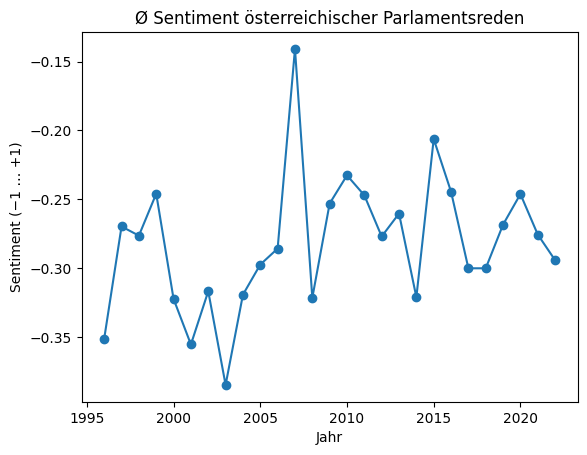

In [21]:
from transformers import pipeline
import pandas as pd
import matplotlib.pyplot as plt

# 1) Stichprobe (z. B. 2000 Zeilen) — für Full Run einfach df_tidy statt sample
df_sample = df_tidy.sample(min(2000, len(df_tidy)), random_state=42).copy()

# 2) Deutsches Sentimentmodell
sent = pipeline("sentiment-analysis", model="oliverguhr/german-sentiment-bert")

# 3) Lange Texte kappen (bis 1000 Zeichen)
def clip(s, n=1000):
    return s[:n] if isinstance(s, str) else s

df_sample["sent_result"] = df_sample["text"].apply(lambda t: sent(clip(t))[0])
df_sample["sent_label"]  = df_sample["sent_result"].str["label"]     # negative/neutral/positive
df_sample["sent_score"]  = df_sample["sent_result"].str["score"]     # Konfidenz

label2num = {"negative": -1, "neutral": 0, "positive": 1}
df_sample["sent_value"] = df_sample["sent_label"].map(label2num)

print(df_sample[["sent_label", "sent_score", "sent_value"]].head())

# 4) Jahres-Trend
by_year = (df_sample
           .dropna(subset=["date"])
           .assign(year=df_sample["date"].dt.year)
           .groupby("year")["sent_value"].mean())

ax = by_year.plot(marker="o", title="Ø Sentiment österreichischer Parlamentsreden")
ax.set_ylabel("Sentiment (−1 … +1)")
ax.set_xlabel("Jahr")
plt.show()


### Top 10 Sprecher*innen (nach Anzahl Redebeiträge)

In [22]:
print("Top 10 Sprecher*innen (nach Anzahl Redebeiträge):")
print(df_tidy["speaker"].value_counts().head(10))

sent_party = (df_sample.groupby("party")["sent_value"]
                        .mean()
                        .sort_values())
print("\nØ Sentiment nach Partei:")
print(sent_party)

Top 10 Sprecher*innen (nach Anzahl Redebeiträge):
speaker
Prammer, Barbara     18944
Fischer, Heinz       18549
Bures, Doris         13571
Sobotka, Wolfgang    10258
Khol, Andreas         8830
Hofer, Norbert        8207
Neugebauer, Fritz     8043
Prinzhorn, Thomas     7939
Graf, Martin          7346
Kopf, Karlheinz       6813
Name: count, dtype: int64

Ø Sentiment nach Partei:
party
STRONACH   -0.769231
GRÜNE      -0.750000
NEOS       -0.708333
BZÖ        -0.625000
LIF        -0.533333
Grüne      -0.448000
FPÖ        -0.287356
SPÖ        -0.250720
-          -0.233333
ÖVP        -0.226837
JETZT       0.000000
Name: sent_value, dtype: float64


#### plot einzel

In [25]:
#mapping = {"negative": -1, "neutral": 0, "positive": 1}
#df_sample["sent_value"] = df_sample["sent_label"].map(mapping)

#sentiment_party = df_sample.groupby("party")["sent_value"].mean().sort_values()
#sentiment_year  = df_sample.groupby(df_sample["date"].dt.year)["sent_value"].mean()

In [26]:
#import matplotlib.pyplot as plt
#sentiment_year.plot(marker="o", title="Ø Sentiment österreichischer Parlamentsreden (1996–2022)")
#plt.ylabel("Sentimentwert (−1 bis +1)")
#plt.xlabel("Jahr")
#plt.show()
